# 用线性方法处理分类问题——逻辑回归

实际上线性模型也可以用于分类任务。方法是把一个线性模型拟合成某个类型的概率分布，然后用一个函数建立阈值来确定结果属于哪一类。

<!-- TEASER_END -->

## Getting ready

这里用的函数是经典的逻辑函数。一个非常简单的函数：

$$f(x)= \frac 1 {1+e^{-t}}$$

它的图形如下图所示：

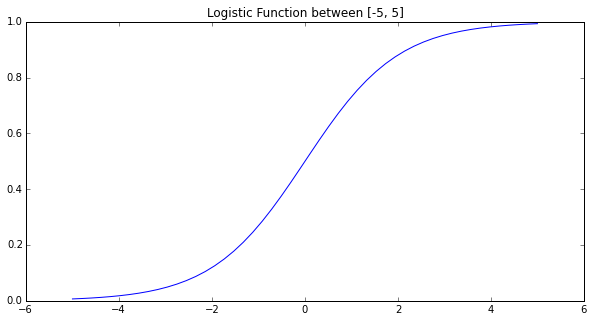

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 5))
rng = np.linspace(-5, 5)
log_f = np.apply_along_axis(lambda x:1 / (1 + np.exp(-x)), 0, rng)
ax.set_title("Logistic Function between [-5, 5]")
ax.plot(rng, log_f);

让我们用`make_classification`方法创建一个数据集来进行分类：

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4)

## How to do it...

`LogisticRegression`对象和其他线性模型的用法一样：

In [3]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

我们将把前面200个数据作为训练集，最后200个数据作为测试集。因为这是随机数据集，所以用最后200个数据没问题。但是如果处理具有某种结构的数据，就不能这么做了（例如，你的数据集是时间序列数据）：

In [4]:
X_train = X[:-200]
X_test = X[-200:]
y_train = y[:-200]
y_test = y[-200:]

在本书后面的内容里，我们将详细介绍交叉检验。这里，我们需要的只是用逻辑回归拟合模型。我们会关注训练集的预测结果，就像测试集预测结果一样。经常对比两个数据集预测正确率是个好做法。通常，你在训练集获得的结果更好；模型在测试集上预测失败的比例也至关重要：

In [5]:
lr.fit(X_train, y_train)
y_train_predictions = lr.predict(X_train)
y_test_predictions = lr.predict(X_test)

现在我们有了预测值，让我们看看预测的效果。这里，我们只简单看看预测正确的比例；后面，我们会详细的介绍分类模型效果的评估方法。

计算很简单，就是用预测正确的数量除以总样本数：

In [6]:
(y_train_predictions == y_train).sum().astype(float) / y_train.shape[0]

0.89375000000000004

测试集的效果是：

In [7]:
(y_test_predictions == y_test).sum().astype(float) / y_test.shape[0]

0.90500000000000003

可以看到，测试集的正确率和训练集的结果差不多。但是实际中通常差别很大。

现在问题变成，怎么把逻辑函数转换成分类方法。

首先，线性回归希望找到一个线性方程拟合出给定自变量$X$条件下因变量$Y$的期望值，就是$E(Y|X)=x \beta$。这里$Y$的值是某个类型发生的概率。因此，我们要解决的分类问题就是$E(p|X)=x \beta$。然后，只要阈值确定，就会有$Logit(p) = X \beta$。这个理念的扩展形式可以构成许多形式的回归行为，例如，泊松过程（Poisson）。

## There's more...

下面的内容你以后肯定会遇到。一种情况是一个类型与其他类型的权重不同；例如，一个能可能权重很大，99%。这种情况在分类工作中经常遇到。经典案例就是信用卡虚假交易检测，大多数交易都不是虚假交易，但是不同类型误判的成本相差很大。

让我们建立一个分类问题，类型$y$的不平衡权重95%，我们看看基本的逻辑回归模型如何处理这类问题：

In [8]:
X, y = make_classification(n_samples=5000, n_features=4, weights=[.95])
sum(y) / (len(y)*1.) #检查不平衡的类型

0.0562

建立训练集和测试集，然后用逻辑回归拟合：

In [9]:
X_train = X[:-500]
X_test = X[-500:]
y_train = y[:-500]
y_test = y[-500:]

lr.fit(X_train, y_train)
y_train_predictions = lr.predict(X_train)
y_test_predictions = lr.predict(X_test)

现在我们在看看模型拟合的情况：

In [10]:
(y_train_predictions == y_train).sum().astype(float) / y_train.shape[0]

0.96711111111111114

In [11]:
(y_test_predictions == y_test).sum().astype(float) / y_test.shape[0]

0.96799999999999997

结果看着还不错，但这是说如果我们把一个交易预测成正常交易（或者称为类型0），那么我们有95%左右的可能猜对。如果我们想看看模型对类型1的预测情况，可能就不是那么好了：

In [12]:
(y_test[y_test==1] == y_test_predictions[y_test==1]).sum().astype(float) / y_test[y_test==1].shape[0]

0.5

如果相比正常交易，我们更关心虚假交易；那么这是由商业规则决定的，我们可能会改变预测正确和预测错误的权重。

通常情况下，虚假交易与正常交易的权重与训练集的类型权重的倒数一致。但是，因为我们更关心虚假交易，所有让我们用多重采样（oversample）方法来表示虚假交易与正常交易的权重。

In [13]:
lr = LogisticRegression(class_weight={0: .15, 1: .85})
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.15, 1: 0.85}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

让我们再预测一下结果：

In [14]:
y_train_predictions = lr.predict(X_train)
y_test_predictions = lr.predict(X_test)

In [15]:
(y_test[y_test==1] == y_test_predictions[y_test==1]).sum().astype(float) / y_test[y_test==1].shape[0]

0.70833333333333337

但是，这么做需要付出什么代价？让我们看看：

In [16]:
(y_test_predictions == y_test).sum().astype(float) / y_test.shape[0]

0.93999999999999995

可以看到，准确率降低了3%。这样是否合适由你的问题决定。如果与虚假交易相关的评估成本非常高，那么它就能抵消追踪虚假交易付出的成本。